<h3 style='color:#FF6363'>Importing required libraries</h3>

In [66]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

<h3 style='color:#FF6363'>Creating Static variable</h3>

In [67]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

<h3 style='color:#FF6363'>Downloading dataset tfdataset</h3>

In [68]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage", 
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


<h3 style='color:#FF6363'>Getting class_names</h3>

In [69]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

<h3 style='color:#FF6363'>Some image visualizations</h3>

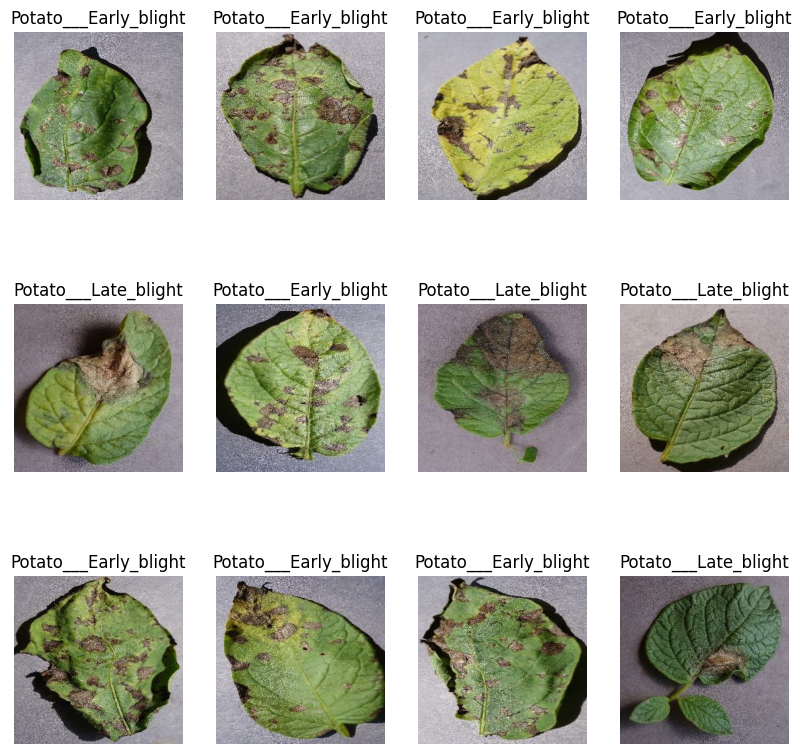

In [70]:
plt.figure(figsize = (10, 10))
for image_batch, label_batch in dataset.take(1):
#     print(image_batch.shape)
#     print(label_batch.numpy())
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

<h3 style='color:#FF6363'>Splitting dataset into training testing and splitting accoring to below %</h3>

80% ==> Training
20% ==> Test
    10% ==> Validation
    10% ==> Testing

In [71]:
train_size = 0.8
train_test_size = int(len(dataset)*train_size)

In [72]:
train_ds = dataset.take(train_test_size)
len(train_ds)

54

In [73]:
test_ds = dataset.skip(train_test_size)
len(test_ds)

14

In [74]:
val_size = 0.1
validation_size = int(len(dataset)*val_size)

In [75]:
val_ds = test_ds.take(validation_size)
len(val_ds)

6

In [76]:
test_ds = test_ds.skip(validation_size)
len(test_ds)

8

<h3 style='color:#FF6363'>All above operations in single functions</h3>

In [77]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split+val_split+test_split) == 1
    
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [78]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

<h3 style='color:#FF6363'>Verifying the lengths of train test and validation datasets</h3>

In [79]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


<h3 style='color:#FF6363'>Saving dataset in catch, shuffling the dataset and prefeching</h3>

In [80]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

<h3 style='color:#FF6363'>Printing single image in numpy and checking it's dimensions</h3>

In [81]:
for image_batch, label_batch in dataset.take(1):
#     print(image_batch[0].numpy().shape) # 256*256*3 where 3 is RGB channel
    print(image_batch[0].numpy()/255)

[[[0.6862745  0.69411767 0.7411765 ]
  [0.7058824  0.7137255  0.7607843 ]
  [0.73333335 0.7411765  0.7882353 ]
  ...
  [0.5254902  0.5176471  0.56078434]
  [0.49803922 0.49019608 0.53333336]
  [0.4509804  0.44313726 0.4862745 ]]

 [[0.7529412  0.7607843  0.80784315]
  [0.7294118  0.7372549  0.78431374]
  [0.7058824  0.7137255  0.7607843 ]
  ...
  [0.5294118  0.52156866 0.5647059 ]
  [0.5019608  0.49411765 0.5372549 ]
  [0.4509804  0.44313726 0.4862745 ]]

 [[0.7294118  0.7372549  0.78431374]
  [0.70980394 0.7176471  0.7647059 ]
  [0.69803923 0.7058824  0.7529412 ]
  ...
  [0.5137255  0.5058824  0.54901963]
  [0.49411765 0.4862745  0.5294118 ]
  [0.45490196 0.44705883 0.49019608]]

 ...

 [[0.62352943 0.6156863  0.6666667 ]
  [0.627451   0.61960787 0.67058825]
  [0.6156863  0.60784316 0.65882355]
  ...
  [0.4627451  0.4509804  0.47843137]
  [0.44313726 0.43137255 0.45882353]
  [0.42745098 0.41568628 0.44313726]]

 [[0.6156863  0.60784316 0.65882355]
  [0.6431373  0.63529414 0.6862745 ]


<h3 style='color:#FF6363'>Data preprocessing --> data resizing and data rescaling</h3>

In [82]:
resize_and_rescale = tf.keras.Sequential([
    # first it will resize the image     
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),

    # second it will rescale the image inbetween 0 and 1
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

<h3 style='color:#FF6363'>Applying some data augmentation techniques</h3>

In [83]:
resize_and_rescale = tf.keras.Sequential([
    # first it will randomly flip the image    
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),

    # second it will randomly rotate the image
    layers.experimental.preprocessing.RandomRotation(0.2)
])